In [ ]:
%cd /content/drive/MyDrive/KDT_2404/m8_비전응용/

/content/drive/MyDrive/KDT_2404/m8_비전응용


In [ ]:
from google.colab.patches import cv2_imshow

#### 오픈 연산 (cv2.MORPH_OPEN)
오픈 연산은 침식 연산(erode) 다음에 팽창 연산(dilate)을 수행하는 것으로 구성됩니다. 이 연산은 다음과 같은 효과를 가집니다:

- 작은 객체나 노이즈를 제거합니다.
- 두 객체 사이의 얇은 연결을 끊습니다.
- 객체의 경계를 부드럽게 합니다.

[ 연산 과정 ]
- 침식 연산: 커널이 위치한 모든 픽셀이 커널과 일치할 때만 원본 이미지의 중심 픽셀을 보존합니다. 이 과정에서 이미지의 작은 노이즈가 제거되고, 객체의 크기가 줄어듭니다.
- 팽창 연산: 커널과 하나라도 픽셀이 겹치는 경우, 원본 이미지의 중심 픽셀을 커널로 설정된 값으로 변경합니다. 침식에서 줄어든 객체의 크기가 다시 증가하면서, 노이즈는 제거된 상태를 유지합니다.

In [ ]:
!pwd

/content/drive/MyDrive/KDT_2404/m8_비전응용


작업 Flow
- 이미지 전처리: 동전 이미지를 그레이스케일로 변환하고 블러링, 이진화를 통해 동전만 분리합니다.
- 윤곽선 검출: 전처리된 이미지에서 외곽선을 찾아 동전의 중심과 크기를 계산합니다.
- 원 그리기: 검출된 동전의 윤곽에 원을 그려 시각적으로 동전을 표시합니다.
- 결과 출력: 전처리된 이진화 이미지와 동전이 검출된 이미지를 Colab에서 출력합니다.

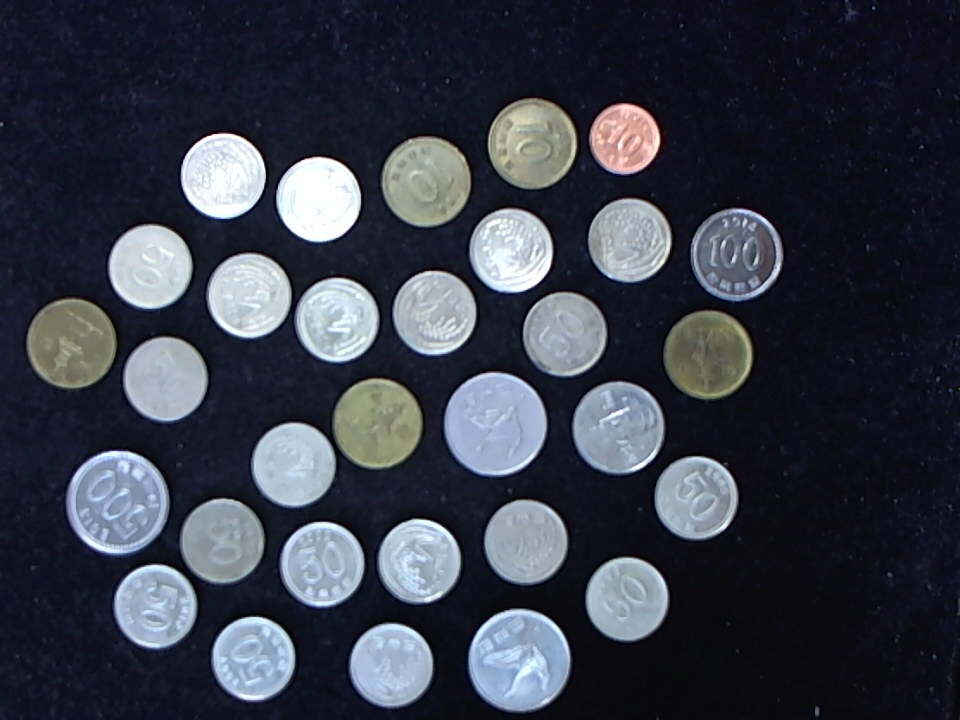

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

fname = 'data/65.png'
img = cv2.imread(fname)
cv2_imshow(img)

Preprocessed image: 


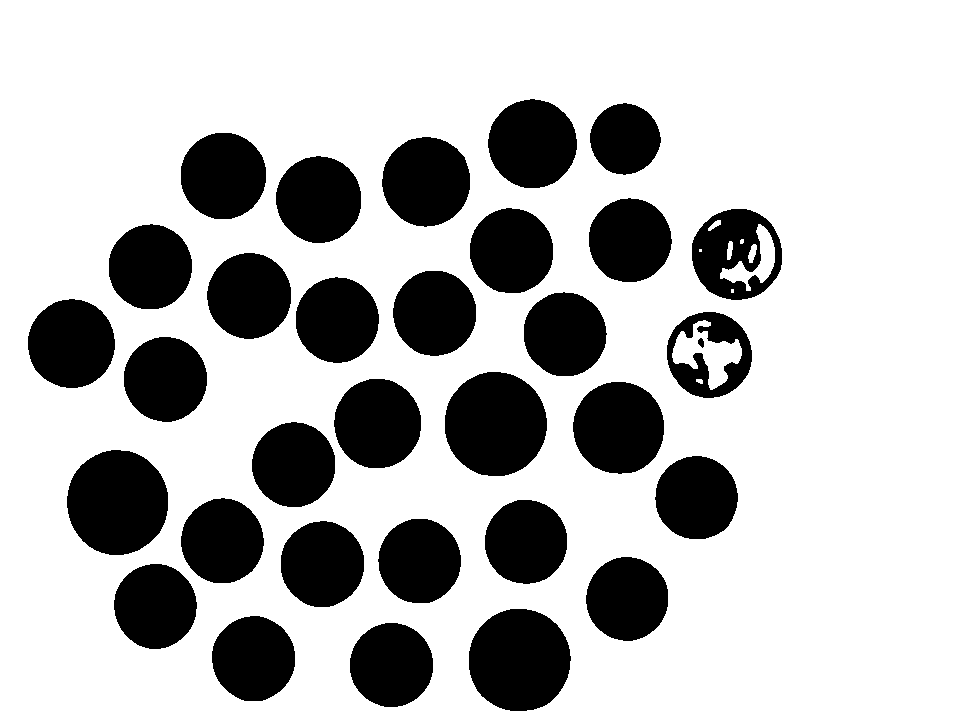

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 주어진 동전 영상 번호를 바탕으로 동전 영상을 읽고, 그레이스케일로 변환 후 블러링과 이진화를 수행한 후 오픈 연산을 통해 작은 노이즈를 제거
# 전처리 함수 만들기
def preprocessing(coin_no):
    fname = f"data/{coin_no:02d}.png"
    img = cv2.imread(fname, cv2.IMREAD_COLOR)   # 이미지 읽기
    if img is None: return None, None           # None이 두번 사용된 이유는 이 함수가 기본적으로 이미지 두개(img와 th_img)를 반환하기 때문

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # 명암도 이미지 변환
    # 그레이 스케일 이미지에 가우신 블러를 적용, 이미지의 노이즈를 줄이고, 세부적인 정보를 감소시킴, 이진화 과정에서 배경과 동전을 잘 구분하기 위해 필요
    blur = cv2.GaussianBlur(gray, (7, 7), 2, 2)     #
    # OTSU 알고리즘을 이용해 최적의 임계값을 자동으로 계산하고 이를 기반으로 이진화를 수행
    flag = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    # OTSU 알고리즘을 사용하여 자동으로 계산된 최적의 임계값으로 gray 이미지를 이진화 하여, 그 결과를 th_img에 저장
    # 픽셀 값이 130 이상인 경우 maxval 값(255)을 할당하고, 130 미만인 경우 0으로 설정
    # OTSU 알고리즘을 사용하여 최적의 임계값을 자동으로 계산하고, 그 값을 사용하여 이미지를 이진화
    _, th_img = cv2.threshold(blur, 0, 255, flag)
    # 3x3 크기의 구조 요소( 커널 )를 생성
    mask = np.ones((3,3), np.uint8)
    # 이진화된 이미지에서 작은 노이즈나 객체를 제거하고, 떨어져있는 객체를 더 명확하게 분리하는 등의 전처리를 수행
    # (열림 연산을 수행, 침식 후 팽창)
    th_img = cv2.morphologyEx(th_img, cv2.MORPH_OPEN, mask) # 열림 연산

    return img, th_img

image, th_img = preprocessing(65) # 전처리 수행
if image is None: raise Exception("이미지 파일 읽기 에러")

print("Preprocessed image: ")
cv2_imshow(th_img) # 첫번째 인자만 전달

OpenCV의 버전에 따라 cv2.findContours() 함수의 반환 값이 달라집니다.

- OpenCV 4.x: 반환 값은 (윤곽선 리스트, 계층 구조)로 되어 있으며, results[0]이 윤곽선 리스트입니다.
- OpenCV 3.x: 반환 값은 (수정된 이미지, 윤곽선 리스트)이며, 윤곽선 리스트는 results[1]입니다.

Coin image:


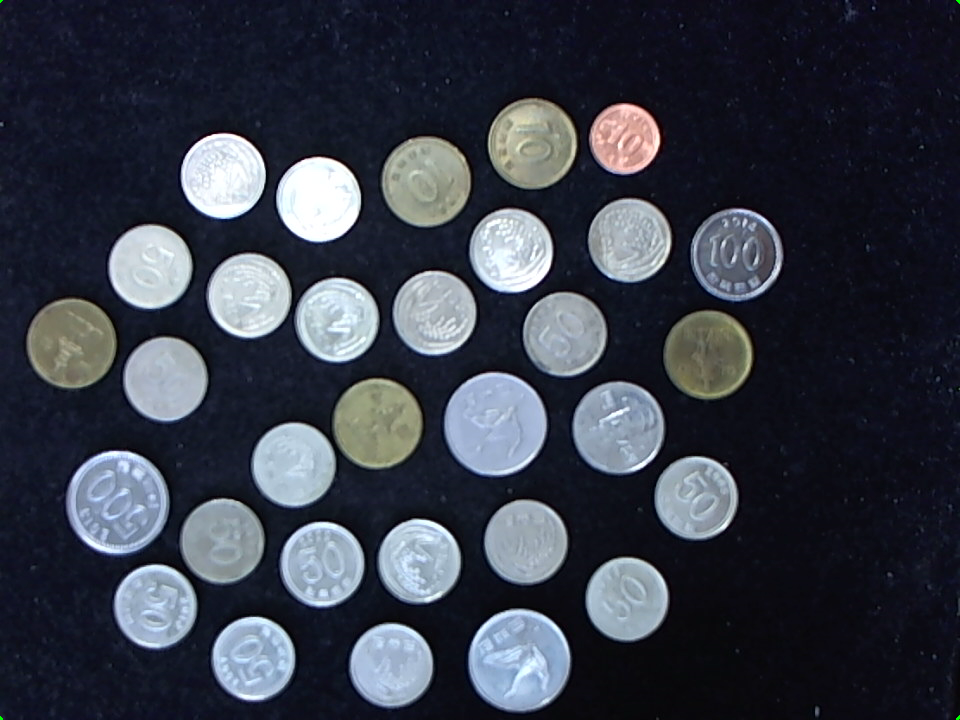

In [ ]:
def find_coins(image):
  # cv2.findContours 함수는 이미지에서 윤곽선을 찾는 데 사용.
  # cv2.RETR_EXTERNAL: 이 옵션은 이미지의 가장 바깥쪽 윤곽선만을 검출. 이는 각 동전의 외곽선만을 찾는 데 적합합니다.
  # cv2.CHAIN_APPROX_SIMPLE: 이 근사 방법은 윤곽선을 구성하는 점들 중 필요한 점들만을 반환하여 메모리를 절약. 예를 들어, 직사각형의 경우 4개의 모서리 점
  results = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # OpenCV 4.x 이상에서 results[0]은 윤곽선 리스트, results[1]은 계층 정보
  # OpenCV 3.x에서 results[0]은 수정된 원본 이미지, results[1]은 윤곽선 리스트
  contours = results[0] if int(cv2.__version__[0]) >= 4 else results[1] # 윤곽선 리스트를 선택하기 위한 조건문

  # 리스트 생성 방식
  circles = [cv2.minEnclosingCircle(c) for c in contours] # 주어진 점들의 집합(여기서는 윤곽선 c)을 모두 포함하는 가장 작은 원을 찾습니다.
  circles = [(tuple(map(int, center)), int(radius)) # 원의 중심 좌표와 반지름을 정수형으로 변환
              for center, radius in circles if radius>25] # 각 원의 반지름이 25 픽셀보다 큰 경우에만 해당 원을 새로운 리스트에 포함
  return circles

# 감지된 각 동전의 중심 좌표와 반지름 정보를 담고 있는 circles 리스트를 반환
circles = find_coins(th_img)
for center, radius in circles:
  # 각 동전의 중심(center), 반지름(radius)에 따라 원을 그립니다. 여기서 (0, 255, 0)은 녹색을 나타내며, 2는 원의 선 두께
  cv2.circle(image, center, radius, (0, 255, 0), 2) # 동전 영상 원으로 표시

print("Coin image:")
cv2_imshow(image) # 첫 번째 인자만 전달

- 마스크 생성: 각 동전의 중심과 반지름을 기준으로 흰색 원이 그려진 검정색 마스크를 생성합니다.
- 동전 영역 추출: 원본 이미지에서 해당 동전이 위치한 사각형 영역을 추출합니다.
- 비트 연산: 마스크를 사용하여 동전 부분만 남기고 나머지 부분은 제거합니다.
- 결과 출력: 마스크가 적용된 최종 동전 이미지를 출력합니다.

In [ ]:
for center, radius in circles[0:2]:
  r = radius * 3
  cen = (r // 2, r // 2) # 중심 좌표 설정
  mask = np.zeros((r, r, 3), np.uint8) # (r, r) 크기의 검정색 빈 마스크를 생성
  cv2.circle(mask, cen, radius, (255,255,255), cv2.FILLED) # 마스크에 **흰색 원(255, 255, 255)**을 그립니다.
  cv2_imshow(mask)
  print()
  coin = cv2.getRectSubPix(image, (r, r), center) # 원본 이미지에서 동전이 위치한 사각형 영역이 추출
  cv2_imshow(coin)
  print()
  # 마스크의 흰색 영역(255,255,255)은 동전의 픽셀 값을 그대로 유지합니다
  # 마스크의 검정색 영역(0,0,0)은 동전 영역 바깥의 픽셀 값을 모두 0으로 만들어 검정색으로 처리합니다
  coin = cv2.bitwise_and(coin, mask)
  cv2_imshow(coin)
  print()

In [ ]:
def make_coin_img(src, circles):
  coins = []
  for center, radius in circles:
    r = radius * 3
    cen = (r // 2, r // 2)
    mask = np.zeros((r, r, 3), np.uint8)
    cv2.circle(mask, cen, radius, (255,255,255), cv2.FILLED)

    coin = cv2.getRectSubPix(src, (r, r), center)
    coin = cv2.bitwise_and(coin, mask)
    coins.append(coin)
  return coins

#### 각 동전의 HSV 색상 히스토그램을 계산하는 과정을 수행

In [ ]:
def calc_histo_hue(coin):
  hsv = cv2.cvtColor(coin, cv2.COLOR_BGR2HSV) # 컬러 공간 변환
  hsize, ranges = [32], [0,180] # 32개의 빈을 사용하여 색상 범위를 나누고 HSV에서 색상 값은 0에서 179사이
  hist = cv2.calcHist([hsv], [0], None, hsize, ranges) # 0은 HSV 이미지의 첫 번째 채널, 즉 색상(Hue) 채널을 의미, hsize: 각 차원별 빈(bin)의 개수
  return hist.flatten() # 차원 히스토그램을 1차원 배열로 변환하여 반환

#### 색상 팔레트 생성 함수(mask_palate)

In [ ]:
# 주어진 행의 수(rows)에 대응하는 HSV 색상 팔레트를 생성하고, 이를 BGR 색상 공간으로 변환하는 과정을 구현
def make_palate(rows):
  hue = [round(i * 180 / rows) for i in range(rows)] # 전체 hue 범위를 row의 수만큼 균일하게 나누어 각 hue 값을 계산
  hsv = [[(h, 255, 255)] for h in hue] # 계산된 hue 값에 대해 채도와 명도를 최대값인 255로 설정하여 HSV 색상을 생성
  hsv = np.array(hsv, np.uint8) # numpy 행렬의 uint8형 변환
  return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

히스토그램 계산 및 시각화
- 색상 팔레트 생성: Hue 값에 따른 색상 팔레트를 생성하여 각 히스토그램 막대의 색상을 결정합니다.
- 히스토그램 값 정규화: cv2.normalize()를 사용해 히스토그램 값을 0에서 최대 높이 값(shape[0], 200)에 맞춰 정규화합니다.
- 막대 그리기: 각 히스토그램 막대는 Hue 색상에 따라 채워집니다. 각 막대의 너비는 히스토그램의 빈(bin) 크기에 따라 결정됩니다.
히스토그램 반환: 최종적으로 막대가 그려진 이미지를 반환합니다.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

coin_no = 65
img, th_img = preprocessing(coin_no)                        # 전처리 수행
circles = find_coins(th_img)                                # 전처리된 이미지에서 동전 검출
coin_imgs = make_coin_img(img, circles)                     # 원본이미지와 검출된 동전 정보를 바탕으로, 각 동전영역만 포함하는 이미지들을 생성
coin_hists = [calc_histo_hue(coin) for coin in coin_imgs]    # 각 동전 이미지에 대해 HSV 색 공간에서 색상(Hue) 채널의 히스토 그램을 계산

# 히스토그램 그리는 함수
def draw_histo_hue(hist, shape=(200,256,3)):
  hsv_palate = make_palate(hist.shape[0])                 # 색상 팔레트 생성
  hist_img = np.full(shape, 255, np.uint8)                # 배경 이미지를 흰색으로 초기화
  cv2.normallize(hist, hist, 0, shape[0], cv2.NORM_MINMAX) # 정규화
  gap = hist_img.shape[1] / hist.shape[0]                 # 한 계급 크기, 히스토그램 이미지의 가로 길이(256 픽셀) / hist.shape[0]: 히스토그램의 빈(bin) 개수

  for i, h in enumerate(hist):
      x, w = int(round(i * gap)), int(round(gap))
      if h > 0:
          color = tuple(map(int, hsv_palate[i][0]))                       # 색상 팔레트에서 해당 인덱스의 색상으로 튜플 변환
          cv2.rectangle(hist_img, (x, 0, w, int(h)), color, cv2.FILLED)   # 팔레트 색으로 그리기

  return cv2.flip(hist_img, 0)    # cv2.flip(hist_img, 0)는 이미지의 세로 축을 기준으로 반전하는 함수
  # return hist_img

# 동전 이미지와 히스토그램을 10열의 그래프로 출력하는 부분
num_coins = len(coin_imgs)
cols = 10
rows = (num_coins * 2 + cols - 1) // cols # 동전의 개수와 히스토그램을 10열에 맞추기 위한 계산

plt.figure(figsize=(20,4 * rows)) # 화면의 크기를 설정

for i, coin in enumerate(coin_imgs):
  # 동전 이미지 출력
  plt.subplot(rows, cols, i + 1)
  plt.imshow(cv2.cv2Color(coin, cv2.COLOR_BGR2RGB))
  plt.title(f"Coin {i+1}")
  plt.axis('off')

  # 히스토그램 출력
  plt.subplot(rows, cols, i + num_coins + 1)
  hist_img = draw_histo_hue(coin_hists[i])
  plt.imshow(cv2.cv2Color(hist_img, cv2.COLOLR_BGR2RGB))
  plt.title(f'Histogram {i+1}')
  plt.axis('off')

plt.tight_layout()
plt.show()

동전 이미지 및 전처리
- preprocessing: 이미지를 전처리합니다. 이 함수는 동전 이미지를 그레이스케일로 변환하고 이진화한 후, 동전의 윤곽을 감지합니다.
- find_coins: 이미지에서 동전을 검출하여, 각 동전의 중심 좌표와 반지름을 찾습니다.
- make_coin_img: 검출된 동전의 영역을 원본 이미지에서 잘라내어 동전 이미지를 생성합니다.
- calc_histo_hue: 각 동전의 색상 히스토그램(Hue 채널)을 계산하여 색상 정보를 추출합니다.

In [ ]:
import numpy as np, cv2, time

coin_no = int(input("동전 이미지 번호: "))
image, th_img = preprocessing(coin_no) # 전처리 수행
circles = find_coins(th_img) # 객체(회전사각형) 검출
coin_imgs = make_coin_img(image, circles) # 동전 이미지 생성
coin_hists = [calc_histo_hue(coin) for coin in coin_imgs] # 동전 이미지 히스토그램

동전 그룹화 함수 (grouping)
- ws: 가중치를 지정하여 특정 색상 구간에 더 많은 비중을 두기 위한 배열입니다. 중간 범위의 색상(즉, 빈도수가 높은 색상)을 더 중요하게 평가합니다.
- np.multiply(hists, ws): 각 동전 히스토그램에 가중치를 적용합니다.
- similaritys: 가중치가 적용된 히스토그램과 전체 히스토그램의 비율을 계산하여 동전의 색상 유사도를 평가합니다.
- groups: 유사도가 특정 값(1.2) 이상이면 동전 그룹을 1로 분류하고, 그렇지 않으면 0으로 분류합니다.

In [ ]:
def grouping(hists):
  # ws 리스트는 히스토그램의 각 빈(bin)에 적용될 가중치를 정의. 색상 분포의 특정 범위를 더 중요하게 다루고자 하는 의도를 반영
  # 중간 범위의 색상(즉, 리스트의 중간에 위치한 값들)이 더 중요하게 평가되어, 그 색상의 빈도가 높은 이미지가 특정 조건을 만족시키는 것으로 간주

  ws = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3,
        4, 5, 6, 8, 6, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0] # 가중치 지정

  sim = np.multiply(hists, ws) # 각 히스토그램에 가중치를 적용
  # 이 비율은 가중치가 적용된 색상 값이 원래 색상 값에서 얼마나 큰 비율을 차지하는지를 나타내며
  # 어떤 동전이 특정 색상에 더 많이 포함되어 있다면, 이 색상이 중요한 색상(가중치가 높은 색상)일수록 그 동전은 더 높은 유사도 값을 가지게 됩니다.
  similaritys = np.sum(sim, axis=1) / np.sum(hists, axis=1)
  # 계산된 유사도가 특정 임계값(여기서는 1.2)을 초과하는지 여부에 따라 히스토그램을 분류
  # 히스토그램의 유사도를 평가하는 기준점은 특정 문제나 데이터에 대한 사전 지식, 실험, 또는 경험적인 조정을 통해 정해집니다.
  groups = [1 if s > 1.2 else 0 for s in similaritys]

  return groups

각 그룹에 속한 반지름 값의 범위에 따라 동전의 종류가 설정됩니다.

첫 번째 그룹 (group 0):
- g[0, 26:47] = 0: 반지름이 26에서 46 사이인 동전은 종류 0에 속합니다.
- g[0, 47:50] = 2: 반지름이 47에서 49 사이인 동전은 종류 2에 속합니다.
- g[0, 50:] = 3: 반지름이 50 이상인 동전은 종류 3에 속합니다.

두 번째 그룹 (group 1):
- g[1, 36:44] = 1: 반지름이 36에서 43 사이인 동전은 종류 1에 속합니다.
- g[1, 44:50] = 2: 반지름이 44에서 49 사이인 동전은 종류 2에 속합니다.
- g[1, 50:] = 3: 반지름이 50 이상인 동전은 종류 3에 속합니다.
이 매핑은 색상 그룹과 반지름 범위에 따라 동전을 네 가지 종류(0, 1, 2, 3)로 분류하는 규칙을 정의한 것입니다. 이 규칙은 사전 지식이나 실험적인 데이터에 기반해 설정

In [ ]:
def classify_coins(circles, groups):
  ncoins = [0] * 4 # 네 가지 종류의 동전을 카운트할 리스트를 초기화. [0] * 4는 [0, 0, 0, 0]과 동일
  g = np.full((2, 70), -1, np.int32) # 배열의 크기는 2x70으로, 여기서 2는 그룹의 수를, 70은 반지름의 최대 가정된 값 범위, 모든 값을 -1로 초기화
  # 각 그룹의 반지름 범위는 사전 지식 또는 실험적인 데이터를 바탕으로 설정
  # g[0, 26:47] = 0은 첫 번재 그룹(group = 0)에서 반지름이 26부터 46까지인 동전을 종류 0으로 분류
  g[0, 26:47], g[0, 47:50], g[0, 50:] = 0, 2, 3
  g[1, 36:44], g[1, 44:50], g[1, 50:] = 1, 2, 3
  # 해당 동전이 속한 그룹과 반지름을 기준으로 g 배열에서 동전의 종류(coin)를 찾습니다.
  for group, (_, radius) in zip(groups, circles):
    coin = g[group, radius]
    ncoins[coin] += 1

  return np.array(ncoins)

그룹 및 동전 개수 계산
- grouping: 동전들의 색상 히스토그램을 바탕으로 그룹을 나눕니다.
- classify_coins: 그룹과 반지름을 사용해 동전을 종류별로 분류하고, 각 종류의 동전 개수를 계산합니다.

In [ ]:
groups = grouping(coin_hists)
ncoins = classify_coins(circles, groups)

총 금액 계산 및 출력
- coin_value: 동전의 금액 배열입니다. 10원, 50원, 100원, 500원 동전을 나타냅니다.
- ncoins[i]: 각 동전 종류별로 개수를 출력합니다.

In [ ]:
coin_value = np.array([10, 50, 100, 500])
for i in range(4):
  print("%3d원: %3d개" % (coin_value[i], ncoins[i]))

문자 출력 함수(put_string)
- cv2.putText: 이미지에 텍스트를 그립니다. shade로 그림자를 추가해 텍스트가 더 선명하게 보이도록 합니다.
- text: 출력할 텍스트를 받아 이미지에 그림자와 함께 텍스트를 그립니다.

In [ ]:
def put_string(frame, text, pt, value=None, color=(120,200,90)):
  text = str(text) + str(value)
  shade = (pt[0] + 2, pt[1] + 2)
  font = cv2.FONT_HERSHEY_SIMPLEX
  # 이 함수는 먼저 약간 오른쪽 아래로 이동된 검은색 텍스트(그림자)를 그리고, 그 위에 본 텍스트(연두색)를 그립니다.
  # 이로인해 텍스트가 더 두드러져 보이는 그림자 효과를 만들어 냅니다.
  cv2.putText(frame, text, shade, font, 0.7, (0, 0, 0), 2) # 검은색 그림자 텍스트 그리기
  cv2.putText(frame, text, pt, font, 0.7, color, 2) # 본 텍스트 그리기

총 금액 계산 및 이미지에 표시
- total: 모든 동전의 총 금액을 계산합니다.
- put_string: 총 금액을 이미지에 표시합니다.

In [ ]:
total = sum(coin_value * ncoins)
total_str = "Total coin: {:,} Won".format(total)
print(total_str)
put_string(image, total_str, (650, 50), '', (0,230,0))

동전 정보 표시
- 색상 리스트 (color): 동전 그룹에 따라 동전 테두리 색상을 설정합니다.
- cv2.circle: 동전의 중심 좌표와 반지름을 사용하여 동전의 경계선을 그립니다.
- put_string: 동전 번호와 반지름을 이미지에 표시합니다.

In [ ]:
color = [(0,0,250), (255,255,0), (0,250,0), (250,0,255)]
for i, (c,r) in enumerate(circles):
  cv2.circle(image, c, r, color[groups[i]], 2)
  put_string(image, i, (c[0] - 15, c[1] - 10), '', color[2]) # 동전의 중심 좌표 c에서 약간 왼쪽과 위로 이동한 위치에 텍스트가 표시됩니다.
  put_string(image, r, (c[0], c[1] + 15), '', color[3]) # 동전의 **반지름(r)**을 동전 아래쪽에 출력

In [ ]:
print("result image")
cv2_imshow(image) # 첫 번째 인자만 전달

## 전체코드

In [1]:
%cd /content/drive/MyDrive/KDT_2404/m8_비전응용/

/content/drive/MyDrive/KDT_2404/m8_비전응용


In [2]:
import cv2
import numpy as np, cv2, time
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# 주어진 동전 영상 번호를 바탕으로 동전 영상을 읽고, 그레이스케일로 변환 후 블러링과 이진화를 수행한 후 오픈 연산을 통해 작은 노이즈를 제거
# 전처리 함수 만들기
def preprocessing(coin_no):
    fname = f"data/{coin_no:02d}.png"
    img = cv2.imread(fname, cv2.IMREAD_COLOR)   # 이미지 읽기
    if img is None: return None, None           # None이 두번 사용된 이유는 이 함수가 기본적으로 이미지 두개(img와 th_img)를 반환하기 때문

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # 명암도 이미지 변환
    # 그레이 스케일 이미지에 가우신 블러를 적용, 이미지의 노이즈를 줄이고, 세부적인 정보를 감소시킴, 이진화 과정에서 배경과 동전을 잘 구분하기 위해 필요
    blur = cv2.GaussianBlur(gray, (7, 7), 2, 2)     #
    # OTSU 알고리즘을 이용해 최적의 임계값을 자동으로 계산하고 이를 기반으로 이진화를 수행
    flag = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    # OTSU 알고리즘을 사용하여 자동으로 계산된 최적의 임계값으로 gray 이미지를 이진화 하여, 그 결과를 th_img에 저장
    # 픽셀 값이 130 이상인 경우 maxval 값(255)을 할당하고, 130 미만인 경우 0으로 설정
    # OTSU 알고리즘을 사용하여 최적의 임계값을 자동으로 계산하고, 그 값을 사용하여 이미지를 이진화
    _, th_img = cv2.threshold(blur, 0, 255, flag)
    # 3x3 크기의 구조 요소( 커널 )를 생성
    mask = np.ones((3,3), np.uint8)
    # 이진화된 이미지에서 작은 노이즈나 객체를 제거하고, 떨어져있는 객체를 더 명확하게 분리하는 등의 전처리를 수행
    # (열림 연산을 수행, 침식 후 팽창)
    th_img = cv2.morphologyEx(th_img, cv2.MORPH_OPEN, mask) # 열림 연산

    return img, th_img

def find_coins(image):
  # cv2.findContours 함수는 이미지에서 윤곽선을 찾는 데 사용.
  # cv2.RETR_EXTERNAL: 이 옵션은 이미지의 가장 바깥쪽 윤곽선만을 검출. 이는 각 동전의 외곽선만을 찾는 데 적합합니다.
  # cv2.CHAIN_APPROX_SIMPLE: 이 근사 방법은 윤곽선을 구성하는 점들 중 필요한 점들만을 반환하여 메모리를 절약. 예를 들어, 직사각형의 경우 4개의 모서리 점
  results = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # OpenCV 4.x 이상에서 results[0]은 윤곽선 리스트, results[1]은 계층 정보
  # OpenCV 3.x에서 results[0]은 수정된 원본 이미지, results[1]은 윤곽선 리스트
  contours = results[0] if int(cv2.__version__[0]) >= 4 else results[1] # 윤곽선 리스트를 선택하기 위한 조건문

  # 리스트 생성 방식
  circles = [cv2.minEnclosingCircle(c) for c in contours] # 주어진 점들의 집합(여기서는 윤곽선 c)을 모두 포함하는 가장 작은 원을 찾습니다.
  circles = [(tuple(map(int, center)), int(radius)) # 원의 중심 좌표와 반지름을 정수형으로 변환
              for center, radius in circles if radius>25] # 각 원의 반지름이 25 픽셀보다 큰 경우에만 해당 원을 새로운 리스트에 포함
  return circles

def make_coin_img(src, circles):
  coins = []
  for center, radius in circles:
    r = radius * 3
    cen = (r // 2, r // 2)
    mask = np.zeros((r, r, 3), np.uint8)
    cv2.circle(mask, cen, radius, (255,255,255), cv2.FILLED)

    coin = cv2.getRectSubPix(src, (r, r), center)
    coin = cv2.bitwise_and(coin, mask)
    coins.append(coin)
  return coins

def calc_histo_hue(coin):
  hsv = cv2.cvtColor(coin, cv2.COLOR_BGR2HSV) # 컬러 공간 변환
  hsize, ranges = [32], [0,180] # 32개의 빈을 사용하여 색상 범위를 나누고 HSV에서 색상 값은 0에서 179사이
  hist = cv2.calcHist([hsv], [0], None, hsize, ranges) # 0은 HSV 이미지의 첫 번째 채널, 즉 색상(Hue) 채널을 의미, hsize: 각 차원별 빈(bin)의 개수
  return hist.flatten() # 차원 히스토그램을 1차원 배열로 변환하여 반환

# 주어진 행의 수(rows)에 대응하는 HSV 색상 팔레트를 생성하고, 이를 BGR 색상 공간으로 변환하는 과정을 구현
def make_palate(rows):
  hue = [round(i * 180 / rows) for i in range(rows)] # 전체 hue 범위를 row의 수만큼 균일하게 나누어 각 hue 값을 계산
  hsv = [[(h, 255, 255)] for h in hue] # 계산된 hue 값에 대해 채도와 명도를 최대값인 255로 설정하여 HSV 색상을 생성
  hsv = np.array(hsv, np.uint8) # numpy 행렬의 uint8형 변환
  return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def grouping(hists):
  # ws 리스트는 히스토그램의 각 빈(bin)에 적용될 가중치를 정의. 색상 분포의 특정 범위를 더 중요하게 다루고자 하는 의도를 반영
  # 중간 범위의 색상(즉, 리스트의 중간에 위치한 값들)이 더 중요하게 평가되어, 그 색상의 빈도가 높은 이미지가 특정 조건을 만족시키는 것으로 간주

  ws = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3,
        4, 5, 6, 8, 6, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0] # 가중치 지정

  sim = np.multiply(hists, ws) # 각 히스토그램에 가중치를 적용
  # 이 비율은 가중치가 적용된 색상 값이 원래 색상 값에서 얼마나 큰 비율을 차지하는지를 나타내며
  # 어떤 동전이 특정 색상에 더 많이 포함되어 있다면, 이 색상이 중요한 색상(가중치가 높은 색상)일수록 그 동전은 더 높은 유사도 값을 가지게 됩니다.
  similaritys = np.sum(sim, axis=1) / np.sum(hists, axis=1)
  # 계산된 유사도가 특정 임계값(여기서는 1.2)을 초과하는지 여부에 따라 히스토그램을 분류
  # 히스토그램의 유사도를 평가하는 기준점은 특정 문제나 데이터에 대한 사전 지식, 실험, 또는 경험적인 조정을 통해 정해집니다.
  groups = [1 if s > 1.2 else 0 for s in similaritys]

  return groups

def classify_coins(circles, groups):
  ncoins = [0] * 4 # 네 가지 종류의 동전을 카운트할 리스트를 초기화. [0] * 4는 [0, 0, 0, 0]과 동일
  g = np.full((2, 70), -1, np.int32) # 배열의 크기는 2x70으로, 여기서 2는 그룹의 수를, 70은 반지름의 최대 가정된 값 범위, 모든 값을 -1로 초기화
  # 각 그룹의 반지름 범위는 사전 지식 또는 실험적인 데이터를 바탕으로 설정
  # g[0, 26:47] = 0은 첫 번재 그룹(group = 0)에서 반지름이 26부터 46까지인 동전을 종류 0으로 분류
  g[0, 26:47], g[0, 47:50], g[0, 50:] = 0, 2, 3
  g[1, 36:44], g[1, 44:50], g[1, 50:] = 1, 2, 3
  # 해당 동전이 속한 그룹과 반지름을 기준으로 g 배열에서 동전의 종류(coin)를 찾습니다.
  for group, (_, radius) in zip(groups, circles):
    coin = g[group, radius]
    ncoins[coin] += 1

  return np.array(ncoins)

def put_string(frame, text, pt, value=None, color=(120,200,90)):
  text = str(text) + str(value)
  shade = (pt[0] + 2, pt[1] + 2)
  font = cv2.FONT_HERSHEY_SIMPLEX
  # 이 함수는 먼저 약간 오른쪽 아래로 이동된 검은색 텍스트(그림자)를 그리고, 그 위에 본 텍스트(연두색)를 그립니다.
  # 이로인해 텍스트가 더 두드러져 보이는 그림자 효과를 만들어 냅니다.
  cv2.putText(frame, text, shade, font, 0.7, (0, 0, 0), 2) # 검은색 그림자 텍스트 그리기
  cv2.putText(frame, text, pt, font, 0.7, color, 2) # 본 텍스트 그리기

coin_no = int(input("동전 이미지 번호: "))
image, th_img = preprocessing(coin_no) # 전처리 수행
if image is None: raise Exception("이미지 파일 읽기 에러")
circles = find_coins(th_img) # 객체(회전사각형) 검출
coin_imgs = make_coin_img(image, circles) # 동전 이미지 생성
coin_hists = [calc_histo_hue(coin) for coin in coin_imgs] # 동전 이미지 히스토그램

groups = grouping(coin_hists)
ncoins = classify_coins(circles, groups)
coin_value = np.array([10, 50, 100, 500])
total = sum(coin_value * ncoins)
total_str = "Total coin: {:,} Won".format(total)
put_string(image, total_str, (650, 50), '', (0,230,0))

color = [(0,0,250), (255,255,0), (0,250,0), (250,0,255)]
for i, (c,r) in enumerate(circles):
  cv2.circle(image, c, r, color[groups[i]], 2)
  put_string(image, i, (c[0] - 15, c[1] - 10), '', color[2]) # 동전의 중심 좌표 c에서 약간 왼쪽과 위로 이동한 위치에 텍스트가 표시됩니다.
  put_string(image, r, (c[0], c[1] + 15), '', color[3]) # 동전의 **반지름(r)**을 동전 아래쪽에 출력

cv2_imshow(image) # 첫 번째 인자만 전달

동전 이미지 번호: 65


IndexError: index 599 is out of bounds for axis 1 with size 70